In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [2]:
#dataset, model, training
class data(Dataset):
    def __init__(self, x, y):
        
        self.x = torch.from_numpy(x).to(device)
        self.y = torch.from_numpy(y).to(device)
        self.n_samples = self.x.size(0)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
        

In [3]:
xdata, ydata = np.load("datax.npy"), np.load("target.npy")
xtrain, xtest, ytrain, ytest = train_test_split(xdata,ydata, test_size=.2)

train_data = data(xtrain, ytrain)
test_data = data(xtest, ytest)

print(len(train_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=75, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=70, shuffle=True, drop_last=True)

print(len(train_loader), len(test_loader))


15246 3812
203 54


In [4]:
##lstm stuff check how lstm layer works
class extract_tensor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor[:,-1,:] #the usable lstm output is the last matrix of the hidden state

# calculating accuracy in training loop for probabilities  
def accuracy(logits, targets):
    preds = F.softmax(logits, dim=1)
    counts = (torch.argmax(targets,dim=1) == torch.argmax(preds, dim=1)).sum()
    return counts

In [5]:
#building the model
class LSTModel(nn.Module):
    def __init__(self):
        super(LSTModel, self).__init__()
        
        self.input_size = 51
        self.hidden_size = 96
        self.seq_len = 45
        self.outsize = 4
        self.num_layers = 2
        self.batch_first = True
        self.dropout = .15
        
        # i could sum them up in the seq part but i just didnt want to
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                                          num_layers=self.num_layers, batch_first=self.batch_first,
                                          dropout=self.dropout)
        
        self.arch = nn.Sequential(extract_tensor(),
                                 nn.ReLU(),
                                 nn.Flatten(),
                                 nn.Linear(self.hidden_size, self.outsize))
        
        
    def forward(self, x):
        
        batch_size = x.size(0)
        
        #notice this is not in the init section, it is because we want to run the model on different batch sizes (e.g. 64 for training 1 for predicting)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        nn.init.xavier_normal_(h0)
        nn.init.xavier_normal_(c0)
        
        out = self.lstm(x, (h0,c0))
        
        out = self.arch(out)
        return out

model = LSTModel()
model.to(device)

LSTModel(
  (lstm): LSTM(51, 96, num_layers=2, batch_first=True, dropout=0.15)
  (arch): Sequential(
    (0): extract_tensor()
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=96, out_features=4, bias=True)
  )
)

In [6]:
#training loop
num_epochs = 20
total_step = len(train_loader)
lr = 5e-4

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =lr)


correct = 0
for epoch in range(1,num_epochs+1):
    for i, (inputs, outputs) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        outputs = outputs.float().to(device)
        
        logits = model(inputs) 
        
        loss = loss_fn(logits, outputs) #loss fn has softmax in it in pytorch, thats why we work with logits and not predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += accuracy(logits, outputs) #number of correct predictions
        

        
        if (i+1)%(68)==0: #optional loss tracing
            print(f"epoch {epoch}, step {i+1}/{total_step}, loss {loss:.4f}")
    print(f"epoch {epoch}, step {i+1}/{total_step}, loss {loss:.4f}")

    if epoch%6==0: #handmade learning rate scheduler
        lr/=2
    
    acc = correct/(total_step*75) #calculating accuracy on whole dataset
    print(f"accuracy is {acc:.4f}")
    correct = 0 #resetting for next epoch
    
    #early stop ;)
    #if acc >= 0.99:
        #print("acc is achieved")
        #break

epoch 1, step 68/203, loss 1.1716
epoch 1, step 136/203, loss 0.8373
epoch 1, step 203/203, loss 0.7776
accuracy is 0.5219
epoch 2, step 68/203, loss 0.6972
epoch 2, step 136/203, loss 0.4454
epoch 2, step 203/203, loss 0.4514
accuracy is 0.7440
epoch 3, step 68/203, loss 0.3395
epoch 3, step 136/203, loss 0.4052
epoch 3, step 203/203, loss 0.4631
accuracy is 0.8314
epoch 4, step 68/203, loss 0.2846
epoch 4, step 136/203, loss 0.3121
epoch 4, step 203/203, loss 0.4033
accuracy is 0.9089
epoch 5, step 68/203, loss 0.1645
epoch 5, step 136/203, loss 0.3447
epoch 5, step 203/203, loss 0.2434
accuracy is 0.9328
epoch 6, step 68/203, loss 0.0692
epoch 6, step 136/203, loss 0.1407
epoch 6, step 203/203, loss 0.0995
accuracy is 0.9579
epoch 7, step 68/203, loss 0.1743
epoch 7, step 136/203, loss 0.0276
epoch 7, step 203/203, loss 0.1695
accuracy is 0.9601
epoch 8, step 68/203, loss 0.0874
epoch 8, step 136/203, loss 0.1086
epoch 8, step 203/203, loss 0.1454
accuracy is 0.9725
epoch 9, step 68

In [7]:
#validation
preds = []
trgets = []

model.eval()

for inpt, target in test_loader:
    inpt = inpt.float().to(device)
    target = target.float().to(device)
    
    with torch.no_grad(): #running model on samples without calcualting grads / we dont use them
        logit = model(inpt)
        
    pred = F.softmax(logit, dim=1) # calculating probabilities
    
    preds.append(F.one_hot(torch.argmax(pred, dim=1)).cpu().numpy()) #turning probabilities into onehot so that we can calculate confusion matrix
    trgets.append(target.cpu().numpy()) #its already in onehot
    
preds = np.array(preds, dtype=np.int32).reshape(-1,4) #from (steps, batch_size, output) to (samples, output)
trgets = np.array(trgets, dtype=np.int32).reshape(-1,4)
preds.shape, trgets.shape

((3780, 4), (3780, 4))

In [8]:
pr = np.argmax(preds, axis=1)
trues = np.argmax(trgets, axis=1) ## collapsing onehot to index vector among samples

np.unique(pr, return_counts=1), np.unique(trues, return_counts=1) #collapsing columns to see distribution

((array([0, 1, 2, 3], dtype=int64),
  array([1036,  764,  903, 1077], dtype=int64)),
 (array([0, 1, 2, 3], dtype=int64),
  array([1036,  764,  903, 1077], dtype=int64)))

In [9]:
#confusion matrix over one class / notice array names are hard coded (preds, trgets)
def get_matrix(class1):
    zer = 0
    one = 0
    two = 0
    tre = 0

    for inx in range(len(preds)):
        if np.argmax(trgets[inx]) == class1:
            if np.argmax(preds[inx]) == 0:
                zer+=1
            elif np.argmax(preds[inx]) == 1:
                one+=1
            elif np.argmax(preds[inx]) == 2:
                two+=1
            elif np.argmax(preds[inx]) == 3:
                tre+=1
                

    return np.array([zer, one, two, tre], dtype=np.int32)

In [10]:
#calculating stuff
asd = np.concatenate([get_matrix(inx) for inx in range(4)])
asd = asd.reshape(4,4)
print(asd)
asd = np.float32(asd)


for i in range(len(asd)):
    asd[i] = asd[i]/np.sum(asd[i])
    
mat = np.round(asd, 5)
mat

[[1036    0    0    0]
 [   0  764    0    0]
 [   0    0  903    0]
 [   0    0    0 1077]]


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

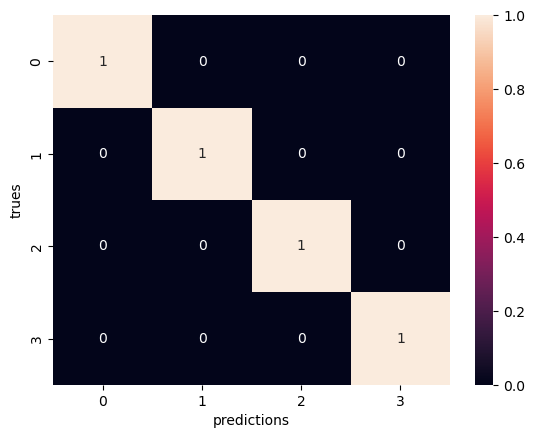

In [11]:
import seaborn as sns
ax = sns.heatmap(mat, annot=True)
ax.set(xlabel="predictions", ylabel="trues")
plt.show()